# Map countries with 2030 targets

In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np
import openclimate as oc
import pandas as pd
import tqdm

from utils import get_target
from utils import actor_parts

# 1. Create CSV of countries with 2030 targets
**NOTE**: This block does not need to be run if the CSV is already created

In [2]:
def has_target(actor_id: str, target_year:int = 2030) -> bool:
    try:
        return any(get_target(actor_id)['target_year'].isin([target_year]))
    except TypeError:
        return False

client = oc.Client()
client.jupyter

df_country_codes = client.country_codes()

target_year = 2030

list_of_dfs = []

for country_code in tqdm.tqdm(df_country_codes['actor_id']):
    df_subnats = actor_parts(country_code)
    if df_subnats is not None:
        data = [{'actor_id': actor_id, f'has_target': has_target(actor_id, target_year=target_year)} 
                      for actor_id in df_subnats.get('actor_id')]
        df_data = pd.DataFrame(data).assign(country_id = country_code)
        list_of_dfs.append(df_data)

df_tmp = pd.concat(list_of_dfs)
df_tmp.to_csv('./subnationals_with_2030_targets.csv', index=False)

list_of_data = []
for country_id in tqdm.tqdm(set(df_tmp.country_id)):
    df_ = df_tmp.loc[df_tmp['country_id'] == country_id]
    perc = df_['has_target'].sum() / len(df_) * 100
    data = {'country_id': country_id, 'percent_with_targets': perc}
    list_of_data.append(data)

df_perc_with_targets = pd.DataFrame(list_of_data)
df_fin = df_country_codes.merge(df_perc_with_targets, left_on='actor_id', right_on='country_id')

# save to file
(
    df_fin
    .sort_values(by='percent_with_targets', ascending=False)
    .to_csv('./percent_of_subnationals_with_2030_targets.csv', index=False)
)

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 197/201 [09:15<00:07,  1.89s/it]

XK does not have any adm1 types


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3568.75it/s]


# 2. Plot percent of subnationals with 2030 targets

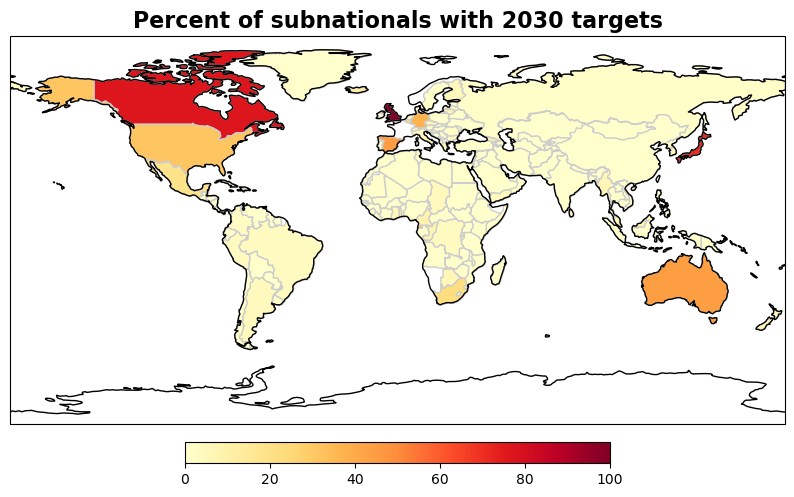

In [3]:
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)

df = pd.read_csv('./percent_of_subnationals_with_2030_targets.csv', na_values=[''])

iso_data = dict(zip(df['actor_id'], df['percent_with_targets']))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

min_value = df['percent_with_targets'].min()
max_value = df['percent_with_targets'].max()

for record in reader.records():
    iso_code = record.attributes['ISO_A2']
    #print(iso_code)
    if iso_code in iso_data:
        value = iso_data[iso_code]
        color_value = (value - min_value) / (max_value - min_value)  # Normalize data to [0, 1]
        ax.add_geometries([record.geometry], ccrs.PlateCarree(),
                          facecolor=plt.cm.YlOrRd(color_value), edgecolor='0.8')

ax.set_title('Percent of subnationals with 2030 targets', fontsize=16, fontweight='bold')
ax.coastlines()
ax.set_xticks([])
ax.set_yticks([])

sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
plt.colorbar(sm, orientation='horizontal', fraction=0.046, pad=0.04)

plt.show()